In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import count
import pickle
import sys
sys.path.append('../..')
import brian_utils.postproc as bup
from brian2 import *

In [4]:
path = '/research/harris/prebot_opioid_model'

In [118]:
shutdown_vals = pd.read_csv(f'{path}/damgo_ramp_sim/connectivity_csv/damgo_ramp_pcon_0.01.csv', usecols=['run_seed', 'I_opioid_shutdown']) 
# look at shutdown values to decide which seeds to use for the figure
shutdown_vals['I_opioid_shutdown'].head(40)

0     5.400000
1     5.060000
2     5.366667
3     4.793333
4     4.573333
5     6.340000
6     5.093333
7     4.433333
8     5.160000
9     4.240000
10    5.120000
11    5.240000
12    6.486667
13    5.086667
14    4.746667
15    5.366667
16    4.746667
17    5.180000
18    5.546667
19    3.733333
20    5.466667
21    5.706667
22    3.886667
23    5.260000
24    5.686667
25    5.333333
26    5.020000
27    6.160000
28    5.040000
29    5.800000
30    6.033333
31    7.506667
32    4.653333
33    5.373333
34    5.286667
35    5.300000
36    5.826667
37    4.866667
38    5.553333
39    4.940000
Name: I_opioid_shutdown, dtype: float64

In [2]:
# choose a low sensitivity seed and a high sensitivity seed
low_sensitivity_seed = 4
high_sensitivity_seed = 32

### Panel A

In [90]:
def plot_pop_rate(rate, sensitivity):
    ctrl_t = (30*second, 60*second)
    damgo_t = (70*second, 100*second)

    binsize = 25 * ms
    smoothed_pop_rate = bup.smooth_saved_rate(rate, binsize)
    burst_stats = bup.pop_burst_stats(rate['t'], smoothed_pop_rate, height = 4, prominence = 10)
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    
    i = 0
    for t in [ctrl_t, damgo_t]:
        rate_idxs = np.where((rate['t'] >= t[0]) & (rate['t'] < t[1]))[0]
        ax[0,i].set_xlim(t)
        ax[0,i].set_xticks([])
        ax[0,i].set_ylim(0,40)
        ax[0,i].set_yticks(np.arange(0,41,10))
        ax[0,i].plot(rate['t'][rate_idxs], smoothed_pop_rate[rate_idxs], 'k', linewidth=1, alpha=0.5)
        ax[0,i].plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "tab:gray")
        ax[0,i].set_xlabel('Time (30 s)')
        ax[0,i].set_ylabel('FR\n(Hz/cell)')
        
        burst_idxs = (burst_stats['Onset Times'] >= t[0]) & (burst_stats['Offset Times'] < t[1])
        burst_window = burst_stats[burst_idxs]
        #burst_window = burst_window.iloc[1:-1]
        for j, burst in burst_window.iterrows():
            ax[1,i].plot(rate['t'][rate_idxs], smoothed_pop_rate[rate_idxs], 'b', linewidth=1, alpha=0.5, c = 'k')
            ax[1,i].plot(burst_window['Peak Times'], smoothed_pop_rate[burst_window['Peak Samples']], ".", c = "tab:gray", markersize=10)
            ax[1,i].axvline(x=burst['Peak Times'], linestyle = '--', c = 'k')
            ax[1,i].axvline(x=burst['Onset Times'], linestyle = '--', c = 'silver', alpha = 0.2)
            ax[1,i].axvline(x=burst['Offset Times'], linestyle = '--', c = 'silver', alpha = 0.2)
            ax[1,i].set_xlim(burst['Peak Times']-1.5, burst['Peak Times']+1.5)
            ax[1,i].set_ylabel('FR\n (Hz/cell)')
            ax[1,i].set_xticks([])
            ax[1,i].set_yticks(np.arange(0,41,10))
            ax[1,i].set_ylim(0,40)
            ax[1,i] = ax[1,i].twiny()
            
        i+=1 

    #plt.savefig(f'fig2_poprate_{sensitivity}_sensitivity.pdf')

In [94]:
with open(f'{path}/data/gleak_mod_pkls/seed{low_sensitivity_seed}-gleak-01_vars.pkl','rb') as fid:
    low_sensitivity_data = pickle.load(fid)
    low_sensitivity_rate = low_sensitivity_data['ratemonitor']
    
with open(f'{path}/data/gleak_mod_pkls/seed{high_sensitivity_seed}-gleak-01_vars.pkl','rb') as fid:
    high_sensitivity_data = pickle.load(fid)
    high_sensitivity_rate = high_sensitivity_data['ratemonitor']

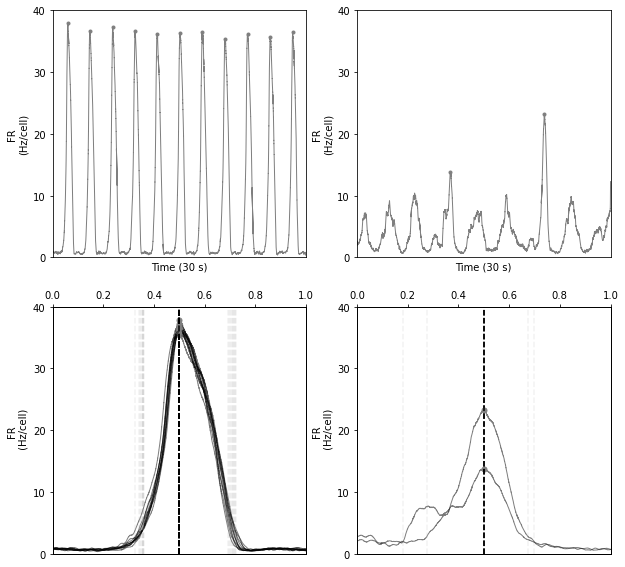

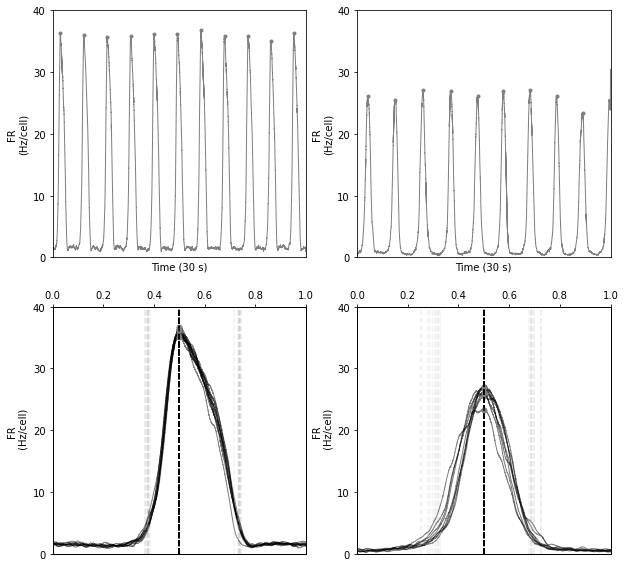

In [78]:
plot_pop_rate(low_sensitivity_rate, sensitivity='low')
plot_pop_rate(high_sensitivity_rate, sensitivity='high')

### Panel B

In [81]:
def plot_phase_diagrams(run_seed, sensitivity='low'): 
    f = plt.figure(figsize=(9,8))
    f.tight_layout()
    g = f.add_gridspec(2, 2)

    data_list = []
    with open(f'{path}/data/gnap_synblock_pkls/clouds_pkls/seed{run_seed}-control_clouds_vars.pkl','rb') as fid1:
        control_data = pickle.load(fid1)

    with open(f'{path}/data/gnap_synblock_pkls/clouds_pkls/seed{run_seed}-damgo_clouds_vars.pkl','rb') as fid2:
        damgo_data = pickle.load(fid2)

    with open(f'{path}/data/gnap_synblock_pkls/grid_pkls/control_grid_vars.pkl','rb') as fid1:
        grid_control_data = pickle.load(fid1)

    with open(f'{path}/data/gnap_synblock_pkls/grid_pkls/damgo_grid_vars.pkl','rb') as fid2:
        grid_damgo_data = pickle.load(fid2)

    data_list.append([control_data, grid_control_data, 'Control'])
    data_list.append([damgo_data, grid_control_data, 'DAMGO'])

    for i in [0,1]: # to handle subplotting
        data_list = []
        data_list.append([control_data, grid_control_data, 'Control'])
        if i == 0:
            data_list.append([damgo_data, grid_control_data, 'DAMGO'])
        else:
            data_list.append([damgo_data, grid_damgo_data, 'DAMGO'])
        j = 0
        for data in data_list:
            neurons = data[0]['neurongroup']
            ts = data[0]['spikemonitor']['t']
            spike_idx = data[0]['spikemonitor']['i']
            train = bup.create_train(ts,spike_idx)
            cell_int, cell_class = bup.find_bursters_pk_ISI(train,300,)

            #state = data[1]['statemonitor']
            grid_neurons = data[1]['neurongroup']
            ts = data[1]['spikemonitor']['t']
            spike_idx = data[1]['spikemonitor']['i']
            train = bup.create_train(ts,spike_idx)
            grid_cell_int, grid_cell_class = bup.find_bursters_pk_ISI(train,400,)

            ax = f.add_subplot(g[i,j])

    #       comment this loop to get rid of phase boundaries (in case we use Illustrator or Inkscape instead)
            for neuron in range(len(grid_cell_int)):
                if grid_cell_int[neuron] == 0:
                    #ax.plot(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='tab:purple', alpha=0.3)
                    ax.scatter(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='tab:purple', marker='s', s=225, alpha=0.3)

                if grid_cell_int[neuron] == 1:
                    #ax.plot(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='gold', alpha=0.3)
                    ax.scatter(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='gold', marker='s',s=225, alpha=0.3)

                if grid_cell_int[neuron] == 2:
                    #ax.plot(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='tab:cyan', alpha=0.3)
                    ax.scatter(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='tab:cyan', marker='s',s=225, alpha=0.3)


            if i == 0:
                for neuron in range(len(cell_int)):
                    if (neuron >= 0 and neuron < 60) or neuron >= 180:
                        if cell_int[neuron] == 0:
                            ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:purple', edgecolor='k', alpha=0.7)

                        if cell_int[neuron] == 1:
                            ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='gold', edgecolor='k', alpha=0.7)

                        if cell_int[neuron] == 2:
                            ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:cyan', edgecolor='k', alpha=0.7)
            else:
                for neuron in range(len(cell_int)):
                    if neuron >= 60 and neuron < 180:
                        if cell_int[neuron] == 0:
                            ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:purple', edgecolor='k', alpha=0.7)

                        if cell_int[neuron] == 1:
                            ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='gold', edgecolor='k', alpha=0.7)

                        if cell_int[neuron] == 2:
                            ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:cyan', edgecolor='k', alpha=0.7)

            ax.set_title('')
            ax.set_xlim(0.3,1.4)
            ax.set_ylim(0.6,1.4)
            ax.set_xlabel(r'$g_{Leak} (nS)$')
            if j == 0:
                ax.set_ylabel(r'$g_{NaP} (nS)$')
            else:
                ax.set_ylabel('')
                ax.set_yticks([])

            j+=1

    plt.savefig(f'fig2_phase_diagrams_{sensitivity}_sensitivity.pdf')

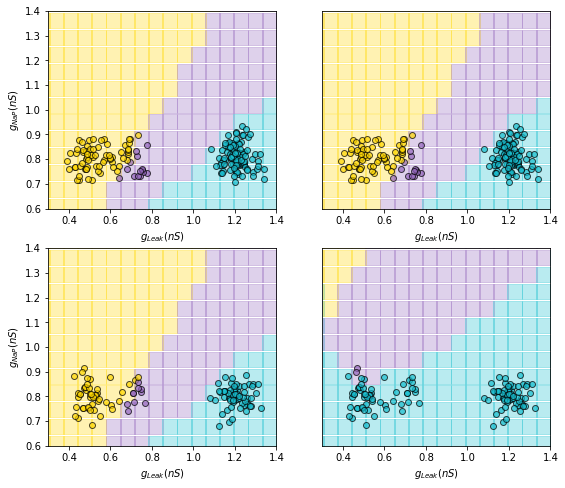

In [82]:
plot_phase_diagrams(low_sensitivity_seed, 'low')

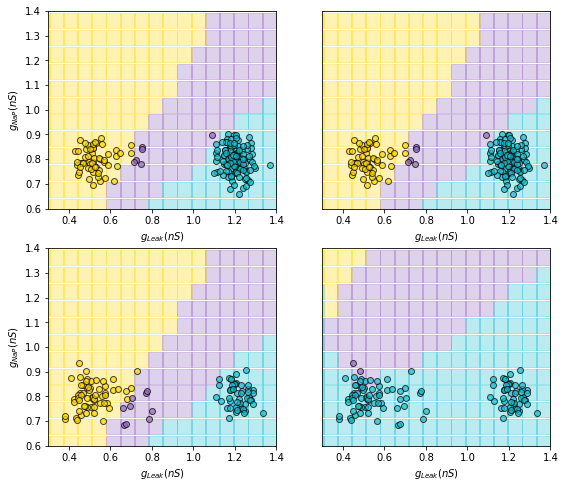

In [10]:
plot_phase_diagrams(high_sensitivity_seed, 'high')

### Panel C

In [83]:
tbq_df = pd.read_csv(f'{path}/synblock_sim/ctrl_damgo_tbq_counts.csv')
tbq_df['Sensitivity'] = np.nan
tbq_df['I_opioid_shutdown'] = shutdown_vals['I_opioid_shutdown']

WARNING    /home/choug/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
 [py.warnings]
WARNING    /home/choug/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
 [py.warnings]
WARNING    /home/choug/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

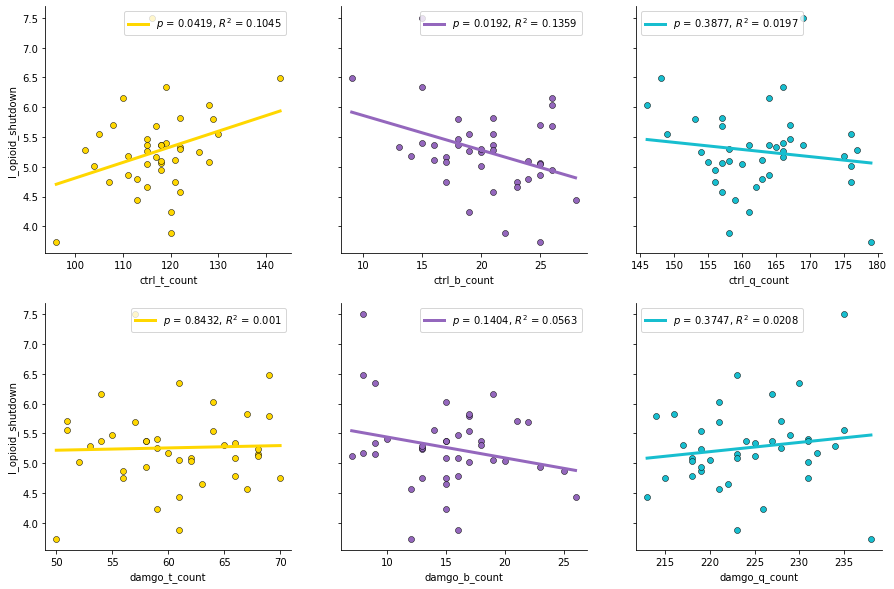

In [115]:
fig, ax = plt.subplots(2,3, figsize=(15,10), sharey=True)
for i in range(2):
    for j in range(3):
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)

conds = ['ctrl', 'damgo']
cells = ['t', 'b', 'q']
colors = ['gold', 'tab:purple', 'tab:cyan']
for i in range(len(conds)):
    cond = conds[i]
    for j in range(len(cells)):
        cell = cells[j]
        x = tbq_df[f'{cond}_{cell}_count']
        y = tbq_df['I_opioid_shutdown']
        sns.scatterplot(x=x, y=y, ax=ax[i,j], color=colors[j], edgecolor='k')
        fit = stats.linregress(x,y)
        label = rf'$p$ = {round(fit.pvalue,4)}, $R^2$ = {round(fit.rvalue**2, 4)}'
        sns.lineplot(x, fit.slope*x + fit.intercept, ax=ax[i,j], color=colors[j], linewidth=3, label=label)
        
plt.savefig('tbq_counts_x_opioid_shutdown.pdf')